# Heston Model vs. Black-Scholes Forecasting Using Real Apple Market Data

In this project, I will be predicting options prices using both the Black-Scholes and Heston Models, then comparing the results with real data. I will use Monte Carlo Methods to simulate stock prices before calculating options prices. I am currently investigating AAPL market data, but it can easily be changed to another stock.

In [1]:
# imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import multiprocessing
from sklearn import metrics
from joblib import Parallel, delayed

## Data Preprocessing

### AAPL Options Data

In [2]:
ticker = yf.Ticker("AAPL")

In [3]:
%%script false --no-raise-error

options_list = []
exps = ticker.options  # expiration dates
# get AAPL options data
for e in exps:
    opt = ticker.option_chain(e)
    opt_df = pd.concat([opt.calls, opt.puts])
    opt_df["expirationDate"] = pd.to_datetime(e)
    options_list.append(opt_df)

# combine all options into one DataFrame
options = pd.concat(options_list, ignore_index=True)

# days until expiration
today = datetime.datetime.today()
options["dte"] = (options["expirationDate"] - today).dt.days
options['T'] = options['dte'] / 365 # years until expiration (T)

# IV
options["impliedVolatility"] = options["impliedVolatility"].replace(0, np.nan)
options = options.dropna(subset=["impliedVolatility"])

# call/put labels
options["option_type"] = options["contractSymbol"].apply(
    lambda x: "Call" if "C" in x else "Put"
)
call = options[options['option_type'] == 'Call']
put = options[options['option_type'] == 'Put']

# Display
options

In [4]:
%%script false --no-raise-error
# Save files
options.to_csv("data/aapl_options.csv")
call.to_csv("data/aapl_call.csv")
put.to_csv("data/nvda_put.csv")

Data collected on: March 4th, 2025:

In [5]:
# reread files (if I don't want to get new data)
options = pd.read_csv("data/aapl_options.csv")
call = pd.read_csv("data/aapl_call.csv")
put = pd.read_csv("data/aapl_put.csv")

In [6]:
%%script false --no-raise-error
# Sample a range of values
strike_series = call["strike"]
dte_series = call["dte"]

selected_strikes = strike_series[(strike_series >= 50) & (strike_series <= 300)].sample(50, random_state=26).values
selected_dte = dte_series.sample(50, random_state=26).values  # Sample 50 random expiration dates

call_selected = call[
    (call['strike'].isin(selected_strikes)) & 
    (call['dte'].isin(selected_dte))
]

print(call_selected)
print("Min DTE:", min(call_selected['dte']))
print("Max DTE:", max(call_selected['dte']))
print("Strike range:", min(call_selected['strike']), "to", max(call_selected['strike']))
print("DTE range:", min(call_selected['dte']), "to", max(call_selected['dte']))

### AAPL Stock Data

As of X, 20XX, AAPL stock price is: $XXX.XX

In [7]:
today_price = ticker.history(period="1d")["Close"].iloc[-1]  
stock = ticker.history()
print(f"Current AAPL Price: ${today_price.round(2)}")
stock

Current AAPL Price: $238.76


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-02-04 00:00:00-05:00,227.000419,232.873966,226.401072,232.544327,45067300,0.00,0.0
2025-02-05 00:00:00-05:00,228.279016,232.414468,228.019307,232.214691,39620300,0.00,0.0
2025-02-06 00:00:00-05:00,231.035979,233.543232,230.176923,232.963867,29925300,0.00,0.0
2025-02-07 00:00:00-05:00,232.344548,233.743004,227.010401,227.380005,39707200,0.00,0.0
2025-02-10 00:00:00-05:00,229.570007,230.589996,227.199997,227.649994,33115600,0.25,0.0
2025-02-11 00:00:00-05:00,228.199997,235.229996,228.130005,232.619995,53718400,0.00,0.0
2025-02-12 00:00:00-05:00,231.199997,236.960007,230.679993,236.869995,45243300,0.00,0.0
2025-02-13 00:00:00-05:00,236.910004,242.339996,235.570007,241.529999,53614100,0.00,0.0
2025-02-14 00:00:00-05:00,241.250000,245.550003,240.990005,244.600006,40896200,0.00,0.0


## Implied Volatility Surface

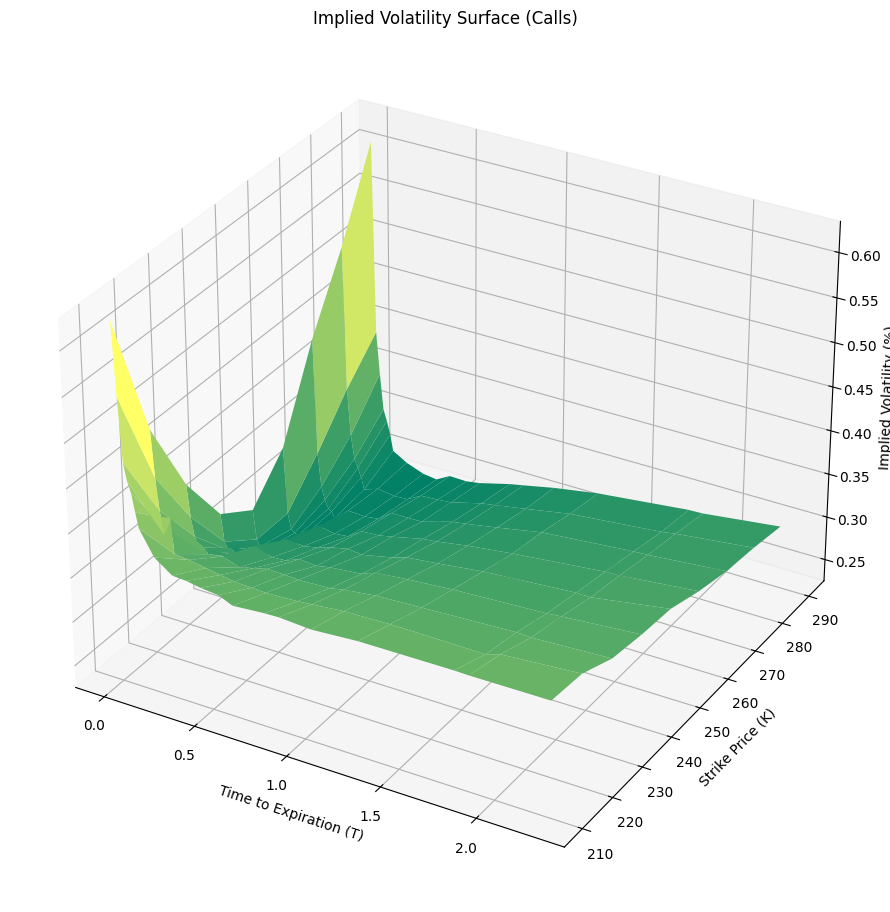

In [8]:
# calls
K, T, iv = call['strike'],  call['T'], call['impliedVolatility']
values = call[['strike', 'T', 'impliedVolatility']].pivot_table(values='impliedVolatility',index='strike',columns='T').dropna()
x, y, z = values.columns, values.index, values.values
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(25,9))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, z, cmap='summer')

# labels and title
plt.tight_layout()
ax.set_ylabel('Strike Price (K)')
ax.set_xlabel('Time to Expiration (T)')
ax.set_zlabel('Implied Volatility (%)')
ax.set_title('Implied Volatility Surface (Calls)')
#ax.view_init(elev=30, azim=240)
plt.show()

## Monte Carlo Simulations of SDE's for Black-Scholes and Heston Models

(description) while closed form solution is better for BS model, i want to be consistent with heston

In [9]:
# Universal Parameters (both models)
N_paths = 10000    # Number of Monte Carlo simulations (INCREASE LATER)
dt = 1/500        # ~ 1/2 trading day time step
r = 0.045         # Risk-free rate
sigma = 0.15      # Volatility (BS), Volatility of Volatility (Heston)

# Heston Parameters
v0 = sigma**2    # Initial variance
kappa = 2        # Mean reversion speed
theta = 0.04     # Long-term variance
rho = -0.7       # Correlation between stock and volatility

# Test Parameters
K = 100          # Strike price
T = 1           # Time to maturity (1/2 year)
S0 = 100         # Initial stock price

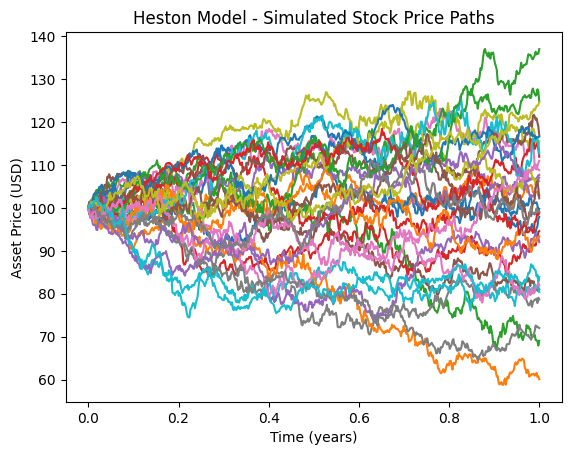

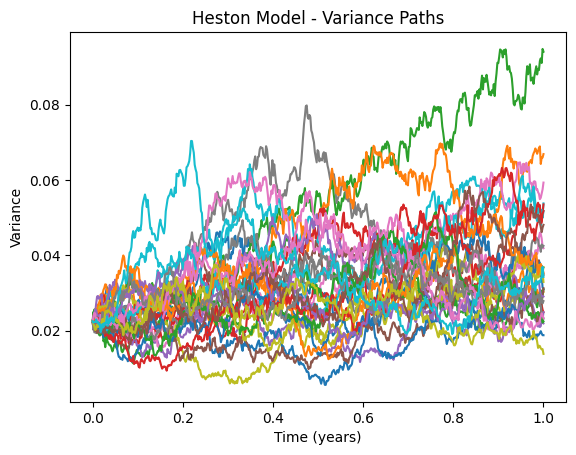

In [10]:
# Heston Model Monte Carlo Simulation
def heston_mc(K, T, N_paths, r, sigma, v0, kappa, theta, rho, dt, S0):
    np.random.seed(26)
    N_steps = int(T / dt)
    t_grid = np.linspace(0, T, N_steps)

    S_paths = np.zeros((N_paths, N_steps))
    v_paths = np.zeros((N_paths, N_steps))

    S_paths[:, 0] = S0
    v_paths[:, 0] = v0

            
    # Generate Brownian motions
    Z1 = np.random.randn(N_paths, N_steps - 1)
    Z2 = np.random.randn(N_paths, N_steps - 1)
    dW_S = Z1 * np.sqrt(dt)
    dW_v = rho * dW_S + np.sqrt(1 - rho**2) * Z2 * np.sqrt(dt)
    # Iterate Through Time Steps
    for t in range(1, N_steps):
        
        v_t = v_paths[:, t-1]
        S_t = S_paths[:, t-1]

        # Volatility Process
        dv = kappa * (theta - v_t) * dt + sigma * np.sqrt(v_t) * dW_v[:, t-1]
        v_paths[:, t] = np.maximum(v_t + dv, 0)

        # Asset Price Process
        dS = r * S_t * dt + np.sqrt(v_paths[:, t]) * S_t * dW_S[:, t-1]
        S_paths[:, t] = S_t + dS

    S_final = S_paths[:, -1]
    # Calculate Call Price
    payoff = np.maximum(S_final - K, 0)
    C = np.exp(-r * T) * np.mean(payoff)

    return t_grid, S_paths, v_paths, C

# Run Heston Monte Carlo
t_grid, S_paths, v_paths, C = heston_mc(K, T, N_paths, r, sigma, v0, kappa, theta, rho, dt, S0)


# plot stock price paths
for i in range(30):
    plt.plot(t_grid, S_paths[i])
    plt.xlabel('Time (years)')
    plt.ylabel('Asset Price (USD)')
    plt.title('Heston Model - Simulated Stock Price Paths')
plt.show()
# plot variance paths
for i in range(30):
    plt.plot(t_grid, v_paths[i])
    plt.xlabel('Time (years)')
    plt.ylabel('Variance')
    plt.title('Heston Model - Variance Paths')
plt.show()

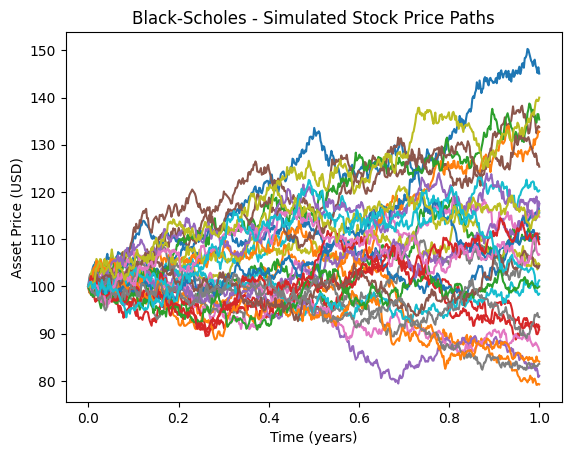

In [11]:
# Black-Scholes Model Monte Carlo Simulation
def bs_mc(K, T, N_paths, r, sigma, dt, S0):
    np.random.seed(26)
    N_steps = int(T / dt)
    t_grid = np.linspace(0, T, N_steps)

    S_paths = np.zeros((N_paths, N_steps))
    S_paths[:, 0] = S0

    # Iterate Through Time Steps
    for t in range(1, N_steps):
        
        dW_S = np.random.randn(N_paths) * np.sqrt(dt)
        S_t = S_paths[:, t-1]
        
        # Asset Price Process
        dS = r * S_t * dt + sigma * S_t * dW_S
        S_paths[:, t] = S_t + dS

    S_final = S_paths[:, -1]
        
    # Calculate Call Price    
    payoff = np.maximum(S_final - K, 0)
    C = np.exp(-r * T) * np.mean(payoff)

    return t_grid, S_paths, C

# Run Black Scholes Monte Carlo
t_grid, S_paths, C = bs_mc(K, T, N_paths, r, sigma, dt, S0)

# plot stock price paths
for i in range(30):
    plt.plot(t_grid, S_paths[i])
    plt.xlabel('Time (years)')
    plt.ylabel('Asset Price (USD)')
    plt.title('Black-Scholes - Simulated Stock Price Paths')
plt.show()

## Results

In [12]:
def nvda_sim(model, data=call):
    prices_sim = []
    for index, row in data.iterrows():
        # initialize
        stock.index = stock.index.tz_localize(None)
        start_date = pd.to_datetime('today')
        S0 = today_price 
        symbol = row['contractSymbol']
        K = row['strike']
        T = row['T']
        sigma = row['impliedVolatility']
        v0 = sigma ** 2
        theta = np.mean(call["impliedVolatility"])**2  
        rho = 0 ### test

        # calculate C using respective model
        if model == 'black-scholes':
            C_nvda = bs_mc(K, T, N_paths, r, sigma, dt, S0)[-1]
        elif model == 'heston':
            C_nvda = heston_mc(K, T, N_paths, r, sigma, v0, kappa, theta, rho, dt, S0)[-1]

        prices_sim.append(C_nvda)
    
    prices_sim = pd.Series(prices_sim) 
    return prices_sim

### Data Comparison

In [13]:
%%time
heston_sim = nvda_sim('heston')
bs_sim = nvda_sim('black-scholes')

CPU times: user 4min 33s, sys: 32.8 s, total: 5min 6s
Wall time: 5min 12s


In [14]:
# construct dataframe of predictions
def make_df(data=call):
    simulated_prices = []
    strikes = []
    symbols = []
    Ts = [] 
    dtes  = []
    for index, row in data.iterrows():
        stock.index = stock.index.tz_localize(None)

        S0 = today_price 
        symbol = row['contractSymbol'] # contract symbol
        K = row['strike']
        T = row['T']
        dte = row['dte']

        strikes.append(K)
        symbols.append(symbol)
        Ts.append(T)
        dtes.append(dte)
    predictions = pd.DataFrame({
        'Contract Symbol': symbols,
        'Strike': strikes,
        'T': Ts,
        'Expiration Date': row['expirationDate'],
        'dte':dtes
        })
    return predictions


In [15]:
prices_sim = make_df()
prices_sim['heston_pred'] = heston_sim
prices_sim['black_scholes_pred'] = bs_sim

### Comparison

In [16]:
# Calculate RMSE, R^2, MSE, MAE, EVS
rmse = np.sqrt(metrics.mean_squared_error(prices_sim['heston_pred'], prices_sim['black_scholes_pred']))
R2 = metrics.r2_score(prices_sim['heston_pred'], prices_sim['black_scholes_pred'])
mse = metrics.mean_squared_error(prices_sim['heston_pred'], prices_sim['black_scholes_pred'])
mae = metrics.mean_absolute_error(prices_sim['heston_pred'], prices_sim['black_scholes_pred'])
evs = metrics.explained_variance_score(prices_sim['heston_pred'], prices_sim['black_scholes_pred'])

# Print the results
print(f'RMSE: {round(rmse, 2)}')
print(f'R^2: {round(R2, 2)}')
print(f'MSE: {round(mse, 2)}')
print(f'MAE: {round(mae, 2)}')
print(f'Explained Variance Score: {round(evs, 2)}')
prices_sim

RMSE: 8.87
R^2: 0.98
MSE: 78.64
MAE: 4.97
Explained Variance Score: 0.98


,Contract Symbol,Strike,T,Expiration Date,dte,heston_pred,black_scholes_pred
0,AAPL250307C00120000,120.0,0.005479,2027-06-17,2,118.545726,118.551111
1,AAPL250307C00130000,130.0,0.005479,2027-06-17,2,108.545828,108.551122
2,AAPL250307C00140000,140.0,0.005479,2027-06-17,2,98.593820,98.598087
3,AAPL250307C00145000,145.0,0.005479,2027-06-17,2,93.605061,93.609070
4,AAPL250307C00150000,150.0,0.005479,2027-06-17,2,88.615990,88.619748
...,...,...,...,...,...,...,...
1055,AAPL270617C00410000,410.0,2.284932,2027-06-17,834,36.413023,8.129533
1056,AAPL270617C00420000,420.0,2.284932,2027-06-17,834,34.921355,7.254669
1057,AAPL270617C00430000,430.0,2.284932,2027-06-17,834,33.478426,6.308863
1058,AAPL270617C00440000,440.0,2.284932,2027-06-17,834,32.160834,5.769371


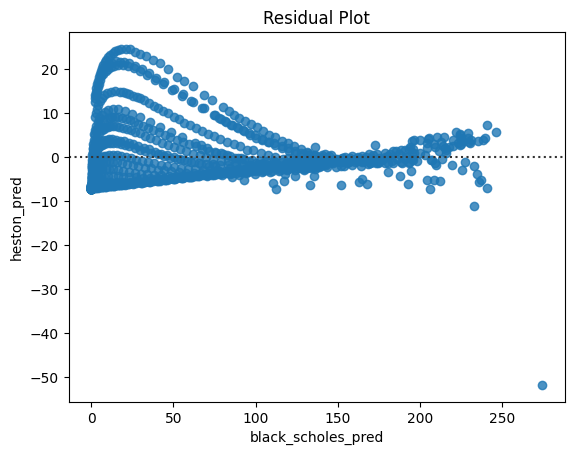

In [17]:
sns.residplot(data=prices_sim, x="black_scholes_pred", y="heston_pred")
plt.title('Residual Plot')
plt.show()

The residuals blow up more around 0, but even out as the predicted price increases.

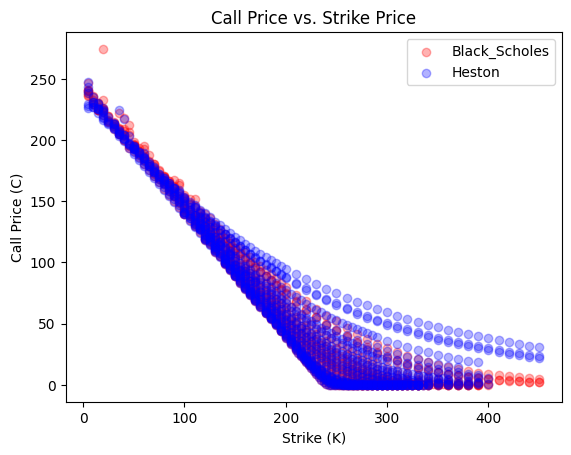

In [18]:
#C vs K
plt.scatter(prices_sim['Strike'], prices_sim['black_scholes_pred'], label='Black_Scholes', alpha=0.3, color='r')
plt.scatter(prices_sim['Strike'], prices_sim['heston_pred'], label='Heston', alpha=0.3, color='b')
plt.title('Call Price vs. Strike Price')
plt.xlabel('Strike (K)')
plt.ylabel('Call Price (C)')
plt.legend()
plt.show()

In [19]:
# save as csv
prices_sim.to_csv("data/predictions.csv")